# Corporación Favorita Grocery Sales Forecast - Part II

Time series forecasting is a broad field with a long history. This course focuses on the application of modern machine learning methods to time series data with the goal of producing the most accurate predictions. The lectures this week and next week will be applicable whenever accurate forecasts are a priority.

After these lectures, you'll know how to:
- engineer features to model the major time series components (*trends*, *seasons*, and *cycles*),
- visualize time series with many kinds of *time series plots*,
- create forecasting *hybrids* that combine the strengths of complementary models, and
- adapt machine learning methods to a variety of forecasting tasks.


## Setting Up the Workspace

In [1]:
# Setup notebook
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.tsa.seasonal import seasonal_decompose

from xgboost import XGBRegressor

import warnings
warnings.simplefilter("ignore")

from IPython import get_ipython
get_ipython().config.InlineBackend.figure_format = 'retina'

#Configure plot styles

plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)


## Defining Plots

In [2]:
# Define lag plot
def lagplot(x, y=None, shift=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(shift)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    title = f"Lag {shift}" if shift > 0 else f"Lead {shift}"
    ax.set(title=f"Lag {shift}", xlabel=x_.name, ylabel=y_.name)
    return ax


In [33]:
#Function to plot lags
def plot_lags(x,
              y=None,
              lags=6,
              leads=None,
              nrows=1,
              lagplot_kwargs={},
              **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    orig = leads is not None
    leads = leads or 0
    kwargs.setdefault('ncols', math.ceil((lags + orig + leads) / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        k -= leads + orig
        if k + 1 <= lags:
            ax = lagplot(x, y, shift=k + 1, ax=ax, **lagplot_kwargs)
            title = f"Lag {k + 1}" if k + 1 >= 0 else f"Lead {-k - 1}"
            ax.set_title(title, fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    print(x,y)
    return fig

## Loading the Data

In [4]:
#Load store sales data (Favorita)
store_sales = pd.read_csv('https://www.dropbox.com/s/amoaj6e3csgh83b/favorita_sales.csv?dl=1')

In [5]:
store_sales

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [6]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [7]:
store_sales.describe().T

,count,mean,std,min,25%,50%,75%,max
id,3000888.0,1.500444e+06,866281.891642,0.0,750221.75,1500443.5,2.250665e+06,3000887.0
store_nbr,3000888.0,2.750000e+01,15.585787,1.0,14.00,27.5,4.100000e+01,54.0
sales,3000888.0,3.577757e+02,1101.997721,0.0,0.00,11.0,1.958473e+02,124717.0
onpromotion,3000888.0,2.602770e+00,12.218882,0.0,0.00,0.0,0.000000e+00,741.0


In [8]:
store_sales.value_counts('store_nbr') # tells all the values and the number of count is there

store_nbr
1     55572
41    55572
30    55572
31    55572
32    55572
33    55572
34    55572
35    55572
36    55572
37    55572
38    55572
39    55572
40    55572
42    55572
2     55572
43    55572
44    55572
45    55572
46    55572
47    55572
48    55572
49    55572
50    55572
51    55572
52    55572
53    55572
29    55572
28    55572
27    55572
26    55572
3     55572
4     55572
5     55572
6     55572
7     55572
8     55572
9     55572
10    55572
11    55572
12    55572
13    55572
14    55572
15    55572
16    55572
17    55572
18    55572
19    55572
20    55572
21    55572
22    55572
23    55572
24    55572
25    55572
54    55572
dtype: int64

In [9]:
store_sales.value_counts('family') # same. each family has 90k data

family
AUTOMOTIVE                    90936
HOME APPLIANCES               90936
SCHOOL AND OFFICE SUPPLIES    90936
PRODUCE                       90936
PREPARED FOODS                90936
POULTRY                       90936
PLAYERS AND ELECTRONICS       90936
PET SUPPLIES                  90936
PERSONAL CARE                 90936
MEATS                         90936
MAGAZINES                     90936
LIQUOR,WINE,BEER              90936
LINGERIE                      90936
LAWN AND GARDEN               90936
LADIESWEAR                    90936
HOME CARE                     90936
HOME AND KITCHEN II           90936
BABY CARE                     90936
HOME AND KITCHEN I            90936
HARDWARE                      90936
GROCERY II                    90936
GROCERY I                     90936
FROZEN FOODS                  90936
EGGS                          90936
DELI                          90936
DAIRY                         90936
CLEANING                      90936
CELEBRATION          

In [10]:
pd.crosstab(store_sales['store_nbr'], store_sales['family']) # values to check number of counts

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
store_nbr,,,,,,,,,,,,,,,,,,,,,
1,1684,1684,1684,1684,1684,1684,1684,1684,1684,1684,...,1684,1684,1684,1684,1684,1684,1684,1684,1684,1684
2,1684,1684,1684,1684,1684,1684,1684,1684,1684,1684,...,1684,1684,1684,1684,1684,1684,1684,1684,1684,1684
3,1684,1684,1684,1684,1684,1684,1684,1684,1684,1684,...,1684,1684,1684,1684,1684,1684,1684,1684,1684,1684
4,1684,1684,1684,1684,1684,1684,1684,1684,1684,1684,...,1684,1684,1684,1684,1684,1684,1684,1684,1684,1684
5,1684,1684,1684,1684,1684,1684,1684,1684,1684,1684,...,1684,1684,1684,1684,1684,1684,1684,1684,1684,1684
6,1684,1684,1684,1684,1684,1684,1684,1684,1684,1684,...,1684,1684,1684,1684,1684,1684,1684,1684,1684,1684
7,1684,1684,1684,1684,1684,1684,1684,1684,1684,1684,...,1684,1684,1684,1684,1684,1684,1684,1684,1684,1684
8,1684,1684,1684,1684,1684,1684,1684,1684,1684,1684,...,1684,1684,1684,1684,1684,1684,1684,1684,1684,1684
9,1684,1684,1684,1684,1684,1684,1684,1684,1684,1684,...,1684,1684,1684,1684,1684,1684,1684,1684,1684,1684


In [13]:
#Load store sales data (Favorita)
store_sales = pd.read_csv('https://www.dropbox.com/s/amoaj6e3csgh83b/favorita_sales.csv?dl=1',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
#Convert days to period type.
store_sales['date'] = store_sales.date.dt.to_period('D')
#Set index of dataframe sorted by store_nbr, product-family-id and the date.
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
store_sales.head(5)

sales  onpromotion
store_nbr family     date                          
1         AUTOMOTIVE 2013-01-01    0.0            0
                     2013-01-02    2.0            0
                     2013-01-03    3.0            0
                     2013-01-04    3.0            0
                     2013-01-05    5.0            0

In [14]:
store_sales.unstack('family')

sales                                                \
family               AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
store_nbr date                                                                  
1         2013-01-01        0.0       0.0    0.0       0.0   0.0     0.000000   
          2013-01-02        2.0       0.0    2.0    1091.0   0.0   470.652008   
          2013-01-03        3.0       0.0    0.0     919.0   0.0   310.654999   
          2013-01-04        3.0       0.0    3.0     953.0   0.0   198.365997   
          2013-01-05        5.0       0.0    3.0    1160.0   0.0   301.057007   
...                         ...       ...    ...       ...   ...          ...   
9         2017-08-11       18.0       1.0    4.0    2619.0   0.0   387.000000   
          2017-08-12        8.0       0.0   14.0    3374.0   0.0   457.000000   
          2017-08-13       15.0       0.0   15.0    3752.0   0.0   485.000000   
          2017-08-14        8.0       0.0    4.0    3367.0   0.0   447.000000   
          2017-08-15       15.0       0.0   10.0    3530.0   0.0   528.000000   

                                                              ... onpromotion  \
family               CELEBRATION CLEANING  DAIRY        DELI  ...   MAGAZINES   
store_nbr date                                                ...               
1         2013-01-01         0.0      0.0    0.0    0.000000  ...           0   
          2013-01-02         0.0   1060.0  579.0  164.069000  ...           0   
          2013-01-03         0.0    836.0  453.0  151.582001  ...           0   
          2013-01-04         0.0    827.0  460.0  131.410995  ...           0   
          2013-01-05         0.0    811.0  464.0  118.612999  ...           0   
...                          ...      ...    ...         ...  ...         ...   
9         2017-08-11        10.0   1496.0  738.0  636.690002  ...           0   
          2017-08-12        18.0   1341.0  767.0  477.782990  ...           0   
          2017-08-13        11.0   1655.0  795.0  503.209015  ...           0   
          2017-08-14        12.0   1429.0  746.0  493.971008  ...           0   
          2017-08-15        16.0   1439.0  835.0  551.713013  ...           0   

                                                                               \
family               MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
store_nbr date                                                                  
1         2013-01-01     0             0            0                       0   
          2013-01-02     0             0            0                       0   
          2013-01-03     0             0            0                       0   
          2013-01-04     0             0            0                       0   
          2013-01-05     0             0            0                       0   
...                    ...           ...          ...                     ...   
9         2017-08-11     0            11            0                       0   
          2017-08-12     0             7            0                       0   
          2017-08-13     0             9            0                       0   
          2017-08-14     0            10            0                       0   
          2017-08-15     0            11            0                       0   

                                                     \
family               POULTRY PREPARED FOODS PRODUCE   
store_nbr date                                        
1         2013-01-01       0              0       0   
          2013-01-02       0              0       0   
          2013-01-03       0              0       0   
          2013-01-04       0              0       0   
          2013-01-05       0              0       0   
...                      ...            ...     ...   
9         2017-08-11      22              3       6   
          2017-08-12       0              1       7   
          2017-0

In [15]:
#Load list of local holidays.
holidays_events = pd.read_csv(
    'https://www.dropbox.com/s/n8ti4jgcfdl84om/favorita_holidays_events.csv?dl=1',
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')
holidays_events.head(5)

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [16]:
#Calculate average sales per day for 2017.
average_sales = (
    store_sales
     #Group all sales by day. For each day compute the average sales from the stores and product families.
    .groupby('date').mean()
    #Select only sales in 2017
    #.loc['2017'] 
)
average_sales.head(5)

,sales,onpromotion
date,,
2013-01-01,1.409438,0.0
2013-01-02,278.390808,0.0
2013-01-03,202.840195,0.0
2013-01-04,198.911148,0.0
2013-01-05,267.873230,0.0


In [17]:
#Calculate average sales per day and product-family for 2017.
family_sales = (
    store_sales
    #Group all sales by day. For each day and product family compute the average sales over all the stores.
    .groupby(['family', 'date']).mean()
    #Move product-family column one level higher
    .unstack('family')
    # Take only sales in 2017 and only the column 'sales' and 'onpromotion'.
    .loc['2017', ['sales', 'onpromotion']]
)
family_sales.head(5)

sales                                              \
family     AUTOMOTIVE BABY CARE     BEAUTY    BEVERAGES     BOOKS   
date                                                                
2017-01-01   0.092593  0.037037   0.055556    74.222221  0.000000   
2017-01-02  11.481482  0.259259  11.648149  6208.055664  0.481481   
2017-01-03   8.296296  0.296296   7.185185  4507.814941  0.814815   
2017-01-04   6.833333  0.333333   6.888889  3911.833252  0.759259   
2017-01-05   6.333333  0.351852   5.925926  3258.796387  0.407407   

                                                                           \
family     BREAD/BAKERY CELEBRATION     CLEANING        DAIRY        DELI   
date                                                                        
2017-01-01     9.084685    0.129630     7.500000    11.518518    3.629167   
2017-01-02   844.836304   14.203704  2233.648193  1545.000000  539.114807   
2017-01-03   665.124084   10.629630  1711.907349  1204.203735  404.300079   
2017-01-04   594.160583   11.185185  1508.036987  1107.796265  309.397675   
2017-01-05   495.511597   12.444445  1241.833374   829.277771  260.776489   

            ... onpromotion                                       \
family      ...   MAGAZINES     MEATS PERSONAL CARE PET SUPPLIES   
date        ...                                                    
2017-01-01  ...         0.0  0.018519      0.111111     0.018519   
2017-01-02  ...         0.0  0.462963     10.592593     0.537037   
2017-01-03  ...         0.0  0.481481      9.722222     0.444444   
2017-01-04  ...         0.0  0.370370     12.037037     0.444444   
2017-01-05  ...         0.0  8.981481      5.666667     0.000000   

                                                                         \
family     PLAYERS AND ELECTRONICS   POULTRY PREPARED FOODS     PRODUCE   
date                                                                      
2017-01-01                     0.0  0.000000       0.037037    0.129630   
2017-01-02                     0.0  0.259259       1.166667    5.629630   
2017-01-03                     0.0  0.388889       1.351852   56.296296   
2017-01-04                     0.0  0.296296       5.444444  101.277778   
2017-01-05                     0.0  0.296296       0.907407    5.018519   

                                                 
family     SCHOOL AND OFFICE SUPPLIES   SEAFOOD  
date                                             
2017-01-01                        0.0  0.000000  
2017-01-02                        0.0  0.407407  
2017-01-03                        0.0  0.407407  
2017-01-04                        0.0  0.333333  
2017-01-05                        0.0  0.444444  

[5 rows x 66 columns]

---
# 2. Time Series as Features

Not every product family has sales showing cyclic behavior, and neither does the series of average sales. Sales of school and office supplies, however, show patterns of growth and decay not well characterized by trend or seasons. In this question and the next, you'll model cycles in sales of school and office supplies using lag features.

Trend and seasonality will both create serial dependence that shows up in correlograms and lag plots. To isolate any purely *cyclic* behavior, we'll start by deseasonalizing the series. Use the code in the next cell to deseasonalize *Supply Sales*. We'll store the result in a variable `y_deseason`.

In [18]:
supply_sales = family_sales.loc(axis=1)[:, 'SCHOOL AND OFFICE SUPPLIES']
y = supply_sales.loc[:, 'sales'].squeeze() #Squeeze data from data-frame into pandas series.
y
supply_sales

,sales,onpromotion
family,SCHOOL AND OFFICE SUPPLIES,SCHOOL AND OFFICE SUPPLIES
date,,
2017-01-01,0.000000,0.000000
2017-01-02,2.925926,0.000000
2017-01-03,2.018518,0.000000
2017-01-04,1.722222,0.000000
2017-01-05,1.425926,0.000000
...,...,...
2017-08-11,65.240738,2.666667
2017-08-12,67.481483,2.759259


In [19]:
y

date
2017-01-01     0.000000
2017-01-02     2.925926
2017-01-03     2.018518
2017-01-04     1.722222
2017-01-05     1.425926
                ...    
2017-08-11    65.240738
2017-08-12    67.481483
2017-08-13    68.851852
2017-08-14    52.333332
2017-08-15    46.851852
Freq: D, Name: SCHOOL AND OFFICE SUPPLIES, Length: 227, dtype: float32

<AxesSubplot:xlabel='date'>

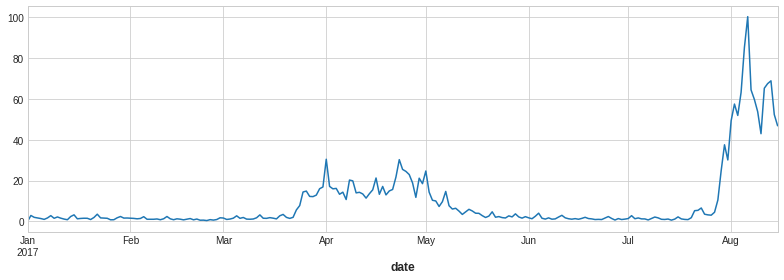

In [20]:
y.plot.line()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)",NewYearsDay
date,,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,True
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,0.394356,0.918958,0.571268,0.820763,0.724793,0.688967,False
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,0.724793,0.688967,0.937752,0.347305,0.998717,-0.050649,False
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,0.937752,0.347305,0.968077,-0.250653,0.651372,-0.758758,False
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,223.0,0.0,0.0,0.0,0.0,1.0,0.0,0.897805,-0.440394,-0.790776,-0.612106,-0.201299,0.979530,0.968077,-0.250653,False
2017-08-12,1.0,224.0,0.0,0.0,0.0,0.0,0.0,1.0,0.790776,-0.612106,-0.968077,-0.250653,0.394356,0.918958,0.485302,-0.874347,False
2017-08-13,1.0,225.0,0.0,0.0,0.0,0.0,0.0,0.0,0.651372,-0.758758,-0.988468,0.151428,0.848644,0.528964,-0.299363,-0.954139,False


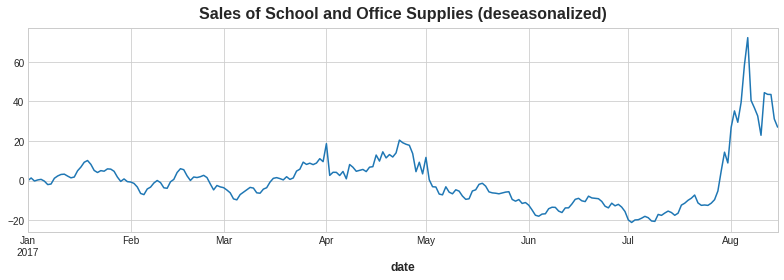

In [22]:
# 4 pairs per month as we did for the full average sales.
fourier = CalendarFourier(freq='M', order=4) # what does M and order mean --> from data it takes M as month and order = 4 is 4 pairs of sin and cos in a month to make a week
dp = DeterministicProcess(
    constant=True,
    index=y.index,
    order=1,
    seasonal=True,
    drop=True,
    additional_terms=[fourier],
)
X_time = dp.in_sample()
#Add one-hot feature for new years day.
X_time['NewYearsDay'] = (X_time.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X_time, y)
y_deseason = y - model.predict(X_time)
y_deseason.name = 'sales_deseasoned'

ax = y_deseason.plot()
ax.set_title("Sales of School and Office Supplies (deseasonalized)");
X_time

Does this deseasonalized series show cyclic patterns? To confirm our intuition, we can try to isolate cyclic behavior using a moving-average plot just like we did with trend. The idea is to choose a window long enough to smooth over short-term seasonality, but short enough to still preserve the cycles.

## Plotting Cycles

Create a seven-day moving average from `y`, the series of supply sales. Use a centered window, but don't set the `min_periods` argument.

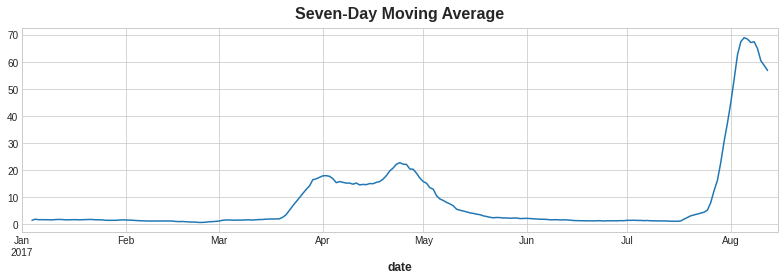

In [23]:
y_ma = y.rolling(
    window=7,         # 7-day window
    center=True,      # puts the average at the center of the window
).mean()              # compute the mean (could also do median, std, min, max, ...)

# Plot
ax = y_ma.plot()
ax.set_title("Seven-Day Moving Average");

### Q: *Do you see how the moving average plot resembles the plot of the deseasonalized series?* 

In both, we can see cyclic behavior indicated.

## Examine Serial Dependence 

Let's examine our deseasonalized series for serial dependence. Take a look at the (partial) autocorrelation correlogram and lag plot.

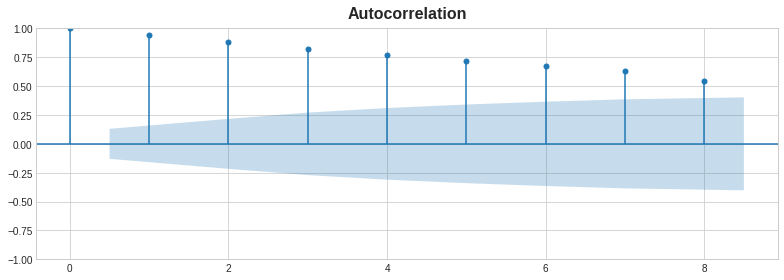

In [24]:
plot_acf(y_deseason, lags=8); #slows decreasing points means that there is reduction and then today is linked to yesterday. 

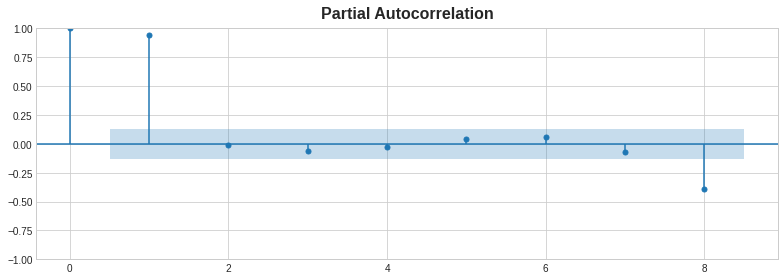

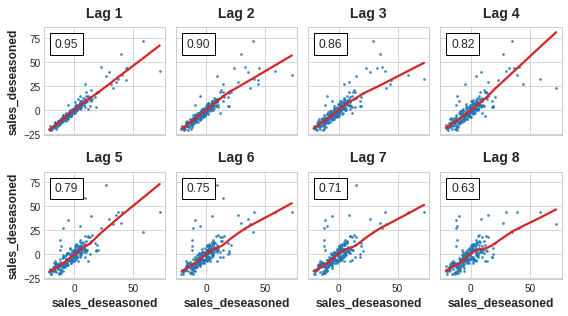

In [25]:
plot_pacf(y_deseason, lags=8); # 1 day only matters. this is different from acf. 
plot_lags(y_deseason, lags=8, nrows=2);

### Q: *Are any of the lags significant according to the correlogram? Does the lag plot suggest any relationships that weren't apparent from the correlogram?*

The correlogram indicates the first lag is likely to be significant. The lag plot suggests the effect is mostly linear.

## Examine Time Series Features

A *leading indicator* is a series whose values at one time can be used to predict the target at a future time -- a leading indicator provides "advance notice" of changes in the target.

The dataset includes a time series that could potentially be useful as a leading indicator -- the `onpromotion` series, which contains the number of items on a special promotion that day. Since the company itself decides when to do a promotion, there's no worry about "lookahead leakage"; we could use Tuesday's `onpromotion` value to forecast sales on Monday, for instance.

Use the next cell to examine leading and lagging values for `onpromotion` plotted against sales of school and office supplies.

date
2017-03-23    1.092593
2017-03-24    1.148148
2017-03-25    1.500000
2017-03-26    1.666667
2017-03-27    1.370370
                ...   
2017-08-11    2.666667
2017-08-12    2.759259
2017-08-13    2.777778
2017-08-14    2.851852
2017-08-15    2.740741
Freq: D, Name: onpromotion, Length: 74, dtype: float64 date
2017-03-23     4.844953
2017-03-24     5.811421
2017-03-25     9.362117
2017-03-26     8.210001
2017-03-27     8.836102
                ...    
2017-08-11    44.466396
2017-08-12    43.602085
2017-08-13    43.543611
2017-08-14    31.196026
2017-08-15    27.057067
Freq: D, Name: sales_deseasoned, Length: 74, dtype: float64


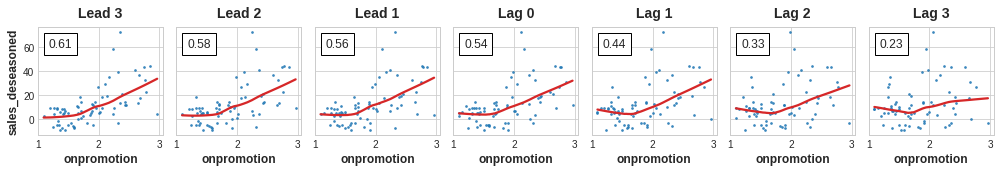

In [34]:
onpromotion = supply_sales.loc[:, 'onpromotion'].squeeze().rename('onpromotion')

# Drop days without promotions
plot_lags(x=onpromotion.loc[onpromotion > 1], y=y_deseason.loc[onpromotion > 1], lags=3, leads=3, nrows=1); #rows to display only

In [31]:
x=onpromotion.loc[onpromotion > 1]
onpromotion

date
2017-01-01    0.000000
2017-01-02    0.000000
2017-01-03    0.000000
2017-01-04    0.000000
2017-01-05    0.000000
                ...   
2017-08-11    2.666667
2017-08-12    2.759259
2017-08-13    2.777778
2017-08-14    2.851852
2017-08-15    2.740741
Freq: D, Name: onpromotion, Length: 227, dtype: float64

In [32]:
y=y_deseason.loc[onpromotion > 1]
y

date
2017-03-23     4.844953
2017-03-24     5.811421
2017-03-25     9.362117
2017-03-26     8.210001
2017-03-27     8.836102
                ...    
2017-08-11    44.466396
2017-08-12    43.602085
2017-08-13    43.543611
2017-08-14    31.196026
2017-08-15    27.057067
Freq: D, Name: sales_deseasoned, Length: 74, dtype: float64

### Q: *Does it appear that either leading or lagging values of `onpromotion` could be useful as a feature?*

The lag plot indicates that both leading and lagged values of `onpromotion` are correlated with supply sales. This suggests that both kinds of values could be useful as features. There may be some non-linear effects as well.

## Create Time Series Features

Create the features indicated above. 

In [58]:
# create dataframe with n='lags' lags with 'lag_time' and prefixed by 'name'
def make_lags(ts, lags, lag_time=1, name='y'):
    return pd.concat(
        {f'{name}_lag_{i}': ts.shift(i)
         for i in range(lag_time, lags + lag_time)},
        axis=1)

# create dataframe with n='leads' leads with 'lead_time' and prefixed by 'name'
def make_leads(ts, leads, lead_time=1, name='y'):
    return pd.concat(
        {f'{name}_lead_{i}': ts.shift(-i)
         for i in reversed(range(lead_time, leads+lead_time))},
        axis=1)

X_lags = make_lags(y_deseason, lags=1, name='y_deseason')

X_promo = pd.concat([
    make_lags(onpromotion, lags=1, name='onpromotion'),
    onpromotion,
    make_leads(onpromotion, leads=1, name='onpromotion'),
], axis=1)

X = pd.concat([X_time, X_lags, X_promo], axis=1).dropna()

# align y with X based on the index (date) and use inner join -- e.g. drop values from y, for which X has a empty (NaN) value
y, X = y.align(X, join='inner')

In [59]:
X.to_csv('1.csv')


In [60]:
X

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,"cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)",NewYearsDay,y_deseason_lag_1,onpromotion_lag_1,onpromotion,onpromotion_lead_1
date,,,,,,,,,,,,,,,,,,,,,
2017-03-23,1.0,82.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.968077,-0.250653,...,-0.874347,0.724793,0.688967,-0.848644,0.528964,False,1.368451,0.000000,1.092593,1.148148
2017-03-24,1.0,83.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.998717,-0.050649,...,-0.994869,0.988468,0.151428,-0.201299,0.979530,False,4.844953,1.092593,1.148148,1.500000
2017-03-25,1.0,84.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.988468,0.151428,...,-0.954139,0.897805,-0.440394,0.571268,0.820763,False,5.811421,1.148148,1.500000,1.666667
2017-03-26,1.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.937752,0.347305,...,-0.758758,0.485302,-0.874347,0.988468,0.151428,False,9.362117,1.500000,1.666667,1.370370
2017-03-27,1.0,86.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.848644,0.528964,...,-0.440394,-0.101168,-0.994869,0.790776,-0.612106,False,8.210001,1.666667,1.370370,1.259259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-10,1.0,222.0,0.0,0.0,0.0,1.0,0.0,0.0,0.968077,-0.250653,...,-0.874347,-0.724793,0.688967,0.848644,0.528964,False,32.714647,2.351852,2.592593,2.666667
2017-08-11,1.0,223.0,0.0,0.0,0.0,0.0,1.0,0.0,0.897805,-0.440394,...,-0.612106,-0.201299,0.979530,0.968077,-0.250653,False,22.931620,2.592593,2.666667,2.759259
2017-08-12,1.0,224.0,0.0,0.0,0.0,0.0,0.0,1.0,0.790776,-0.612106,...,-0.250653,0.394356,0.918958,0.485302,-0.874347,False,44.466396,2.666667,2.759259,2.777778


Visualize predictions from the resulting model.

Training RMSE: 4.23902
Validation RMSE: 14.51306


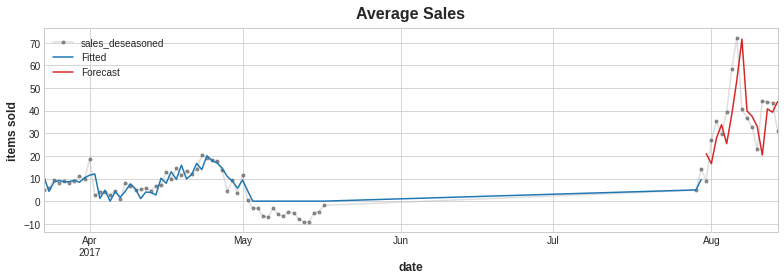

In [61]:


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = pd.Series(model.predict(X_train), index=X_train.index).clip(0.0) #.clip(0.0) removes negative values
y_pred = pd.Series(model.predict(X_valid), index=X_valid.index).clip(0.0) #.clip(0.0) removes negative values

rmse_train = mean_squared_error(y_train, y_fit, squared=False) 
rmse_valid = mean_squared_error(y_valid, y_pred, squared=False) 
print(f'Training RMSE: {rmse_train:.5f}')
print(f'Validation RMSE: {rmse_valid:.5f}')

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_fit.plot(ax=ax, label="Fitted", color='C0')
ax = y_pred.plot(ax=ax, label="Forecast", color='C3')
ax.legend();

In [46]:
print(model.coef_)
print(model.feature_names_in_)

[ 0.56511564  0.10412656 -3.52868408 -3.6724747  -4.92849558 -5.53670855
 -4.69545    -1.60442723  3.6528307   2.87757354  0.15143699  0.0125848
  1.10384848  0.41811541 -0.39763751  0.01102352 -3.98853948]
['const' 'trend' 's(2,7)' 's(3,7)' 's(4,7)' 's(5,7)' 's(6,7)' 's(7,7)'
 'sin(1,freq=M)' 'cos(1,freq=M)' 'sin(2,freq=M)' 'cos(2,freq=M)'
 'sin(3,freq=M)' 'cos(3,freq=M)' 'sin(4,freq=M)' 'cos(4,freq=M)'
 'NewYearsDay']


In [63]:
y_pred

date
2017-07-31    20.957873
2017-08-01    16.565209
2017-08-02    27.806426
2017-08-03    33.799516
2017-08-04    25.402541
2017-08-05    38.143873
2017-08-06    53.438895
2017-08-07    71.602646
2017-08-08    39.849760
2017-08-09    37.462824
2017-08-10    33.036072
2017-08-11    20.374298
2017-08-12    40.797298
2017-08-13    39.301117
2017-08-14    43.985680
Freq: D, dtype: float64

### Cross validation

Can you create a pipeline to do the time series cross validation?

In [48]:
pipe = Pipeline([('lin_reg', LinearRegression(fit_intercept=False))])
cv_scores = (cross_val_score(pipe, X, y, cv=5, scoring='neg_mean_squared_error') * -1) ** 0.5
print (f'CV Mean score {cv_scores.mean()}')
cv_scores 


CV Mean score 11.32086632319581


array([ 8.09050495,  6.01890983, 10.47718535, 15.25592851, 16.76180297])

In [49]:
# Time Series Cross Validation - cv=TimeSeriesSplit(n_splits=4)

ts_cv_scores = (cross_val_score(pipe, X, y, cv=TimeSeriesSplit(n_splits=4), scoring='neg_mean_squared_error') * -1) ** 0.5
print (f'time series cross validation Mean score {ts_cv_scores.mean()}')
ts_cv_scores 

time series cross validation Mean score 26.476122145588825


array([22.97064202, 19.36099391, 46.81104968, 16.76180297])

## Additional Statistical Features

Good forecasting models often include moving averages and other rolling statistics in their feature sets. Such features seem to be especially useful when used with algorithms like XGBoost.

Last class you learned how to compute moving averages to estimate trends. Computing rolling statistics to be used as features is similar except we need to take care to avoid lookahead leakage. First, the result should be set at the right end of the window instead of the center -- that is, we should use `center=False` (the default) in the `rolling` method. Second, the target should be lagged a step.

Create the following features:
- 14-day rolling median (`median`) of lagged target
- 7-day rolling standard deviation (`std`) of lagged target
- 7-day sum (`sum`) of items "on promotion", with centered window

In [64]:
y_lag = supply_sales.loc[:, 'sales'].shift(1)
onpromo = supply_sales.loc[:, 'onpromotion']

mean_7 = y_lag.rolling(7).mean()
median_14 = y_lag.rolling(14).median()
std_7 = y_lag.rolling(7).std()
promo_7 = onpromo.rolling(7, center=True).sum()

Check out the Pandas [`Window` documentation](https://pandas.pydata.org/pandas-docs/stable/reference/window.html) for more statistics you can compute. Also try "exponential weighted" windows by using `ewm` in place of `rolling`; exponential decay is often a more realistic representation of how effects propagate over time.

---
# Hybrid Models

In the next cell, you'll create a boosted hybrid for the *Store Sales* dataset by implementing a new Python class. Run this cell to create the initial class definition. You'll add `fit` and `predict` methods to give it a scikit-learn like interface.


In [65]:
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1  
        self.model_2 = model_2 # Model 2 trains on the residuals of the forecast of model_1
        self.y_columns = None  # store column names from fit method


    def fit(self, X_1, X_2, y):
        # Train model_1
        self.model_1.fit(X_1, y)

        # Make predictions
        y_fit = pd.DataFrame(
            self.model_1.predict(X_1), 
            index=X_1.index, columns=y.columns,
        )

        # Compute residuals
        y_resid = y - y_fit
        y_resid = y_resid.stack().squeeze() # wide to long

        # Train model_2 on residuals
        self.model_2.fit(X_2, y_resid)

        # Save column names for predict method
        self.y_columns = y.columns

        self.y_fit = y_fit
        self.y_resid = y_resid

    def predict(self, X_1, X_2):
        # Predict with model_1
        y_pred = pd.DataFrame(
            self.model_1.predict(X_1), 
            index=X_1.index, columns=self.y_columns,
        )
        y_pred = y_pred.stack().squeeze()  # wide to long

        # Add model_2 predictions to model_1 predictions
        y_pred += self.model_2.predict(X_2)

        return y_pred.unstack()





Now you're ready to use your new `BoostedHybrid` class to create a model for the *Store Sales* data. Run the nextfollowing cells to set up the data for training.

In [66]:
# Target series - Retrieve sales value for each date (row) and product-family (colum)
y = family_sales.loc[:, 'sales']

y


family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.092593,0.037037,0.055556,74.222221,0.000000,9.084685,0.129630,7.500000,11.518518,3.629167,...,0.074074,5.013166,2.629630,0.074074,0.222222,2.855537,1.040722,31.163778,0.000000,0.259259
2017-01-02,11.481482,0.259259,11.648149,6208.055664,0.481481,844.836304,14.203704,2233.648193,1545.000000,539.114807,...,7.777778,488.522339,714.370361,12.814815,22.777779,581.413147,153.555542,3409.500488,2.925926,33.581944
2017-01-03,8.296296,0.296296,7.185185,4507.814941,0.814815,665.124084,10.629630,1711.907349,1204.203735,404.300079,...,3.500000,427.520905,488.333344,8.870370,13.555555,462.013672,125.820534,3394.559814,2.018518,27.135260
2017-01-04,6.833333,0.333333,6.888889,3911.833252,0.759259,594.160583,11.185185,1508.036987,1107.796265,309.397675,...,3.500000,369.121490,426.574066,8.129630,12.092592,431.276398,116.740814,3467.447998,1.722222,22.034130
2017-01-05,6.333333,0.351852,5.925926,3258.796387,0.407407,495.511597,12.444445,1241.833374,829.277771,260.776489,...,3.203704,368.945679,360.925934,7.629630,10.333333,345.673492,101.434570,2069.316650,1.425926,20.615334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,8.166667,0.129630,6.500000,3502.055664,0.000000,522.305298,16.111111,1031.148193,831.648132,345.934967,...,9.259259,498.964661,295.888885,10.870370,12.111111,468.857361,96.286926,2198.854492,65.240738,23.566963
2017-08-12,7.462963,0.055556,6.833333,3376.259277,0.000000,507.473114,15.722222,1072.870361,793.592590,290.553589,...,8.944445,329.178711,294.500000,9.407408,13.185185,354.342773,84.693817,2070.154785,67.481483,19.037592
2017-08-13,8.907408,0.166667,8.018518,3747.296387,0.018519,615.976990,10.074074,1143.648193,928.000000,325.801361,...,8.685185,345.055817,336.814819,10.018518,13.722222,379.801208,91.509422,2331.922363,68.851852,20.704575


In [67]:
# X_1: Features for modeling Trend and Seasonality (e.g. with Linear Regression)
dp = DeterministicProcess(index=y.index, order=1)
X_1 = dp.in_sample()

X_1

,trend
date,
2017-01-01,1.0
2017-01-02,2.0
2017-01-03,3.0
2017-01-04,4.0
2017-01-05,5.0
...,...
2017-08-11,223.0
2017-08-12,224.0
2017-08-13,225.0


In [68]:
# X_2: Features for modeling residuals with a non-linear model (e.g. with Random Forest Regression)
X_2 = family_sales.drop('sales', axis=1)  # onpromotion feature

X_2

onpromotion                                                    \
family      AUTOMOTIVE BABY CARE    BEAUTY  BEVERAGES BOOKS BREAD/BAKERY   
date                                                                       
2017-01-01    0.000000  0.000000  0.000000   0.703704   0.0     0.055556   
2017-01-02    0.222222  0.000000  0.481481  42.314815   0.0     1.907407   
2017-01-03    0.111111  0.000000  0.444444  41.000000   0.0     2.000000   
2017-01-04    0.111111  0.000000  0.925926  55.222222   0.0     6.925926   
2017-01-05    0.092593  0.018519  0.907407  31.166667   0.0     6.222222   
...                ...       ...       ...        ...   ...          ...   
2017-08-11    0.000000  0.000000  0.870370  17.796296   0.0     8.907407   
2017-08-12    0.018519  0.000000  1.000000  17.703704   0.0     8.833333   
2017-08-13    0.000000  0.000000  1.018519  18.259259   0.0    32.222222   
2017-08-14    0.000000  0.000000  0.925926  17.722222   0.0     9.074074   
2017-08-15    0.018519  0.000000  1.018519  18.185185   0.0     9.481481   

                                                         ...            \
family     CELEBRATION   CLEANING      DAIRY       DELI  ... MAGAZINES   
date                                                     ...             
2017-01-01    0.000000   0.203704   0.222222   0.166667  ...       0.0   
2017-01-02    0.351852  14.166667  13.518519   9.018519  ...       0.0   
2017-01-03    0.370370  15.092593  13.870370   8.944444  ...       0.0   
2017-01-04    0.407407  18.462963  71.925926   8.666667  ...       0.0   
2017-01-05    0.185185  12.814815  18.944444   0.629630  ...       0.0   
...                ...        ...        ...        ...  ...       ...   
2017-08-11    0.000000  17.166667  18.203704  55.074074  ...       0.0   
2017-08-12    0.018519  16.925926  18.555556   6.444444  ...       0.0   
2017-08-13    0.000000  17.000000  18.462963   6.814815  ...       0.0   
2017-08-14    0.000000  15.555556  18.111111   6.592593  ...       0.0   
2017-08-15    0.000000  15.574074  18.092593   6.314815  ...       0.0   

                                                                          \
family          MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                       
2017-01-01   0.018519      0.111111     0.018519                0.000000   
2017-01-02   0.462963     10.592593     0.537037                0.000000   
2017-01-03   0.481481      9.722222     0.444444                0.000000   
2017-01-04   0.370370     12.037037     0.444444                0.000000   
2017-01-05   8.981481      5.666667     0.000000                0.000000   
...               ...           ...          ...                     ...   
2017-08-11  22.925926      9.000000     0.000000                0.000000   
2017-08-12   0.000000      8.703704     0.000000                0.018519   
2017-08-13   0.000000      9.240741     0.000000                0.000000   
2017-08-14   0.000000      8.722222     0.000000                0.000000   
2017-08-15   0.000000      8.814815     0.000000                0.092593   

                                                                             \
family        POULTRY PREPARED FOODS     PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                          
2017-01-01   0.000000       0.037037    0.129630                   0.000000   
2017-01-02   0.259259       1.166667    5.629630                   0.000000   
2017-01-03   0.388889       1.351852   56.296296                   0.000000   
2017-01-04   0.296296       5.444444  101.277778                   0.000000   
2017-01-05   0.296296       0.907407    5.018519                   0.000000   
...               ...            ...         ...                        ...   
2017-08-11  27.407407       0.537037    6.000000                   2.666667   
2017-08-12   0.111111       0.277778    6.000000      

In [69]:
X_2 = family_sales.drop('sales', axis=1).stack()  # onpromotion feature, stacked
X_2

onpromotion
date       family                                 
2017-01-01 AUTOMOTIVE                     0.000000
           BABY CARE                      0.000000
           BEAUTY                         0.000000
           BEVERAGES                      0.703704
           BOOKS                          0.000000
...                                            ...
2017-08-15 POULTRY                        0.111111
           PREPARED FOODS                 0.166667
           PRODUCE                       58.685185
           SCHOOL AND OFFICE SUPPLIES     2.740741
           SEAFOOD                        0.000000

[7491 rows x 1 columns]

In [70]:
# Label encoding for 'family'
le = LabelEncoder()  # from sklearn.preprocessing.
#LabelEncoder works the same as OrdinalEncoder, but is intended for targetvalues and accepts only a single series/column at a time.
X_2 = X_2.reset_index('family')
X_2['family'] = le.fit_transform(X_2['family']) # Encode each product family as a number

# Label encoding for seasonality
X_2["day"] = X_2.index.day  # values are day of the month

In [71]:
X_2

,family,onpromotion,day
date,,,
2017-01-01,0,0.000000,1
2017-01-01,1,0.000000,1
2017-01-01,2,0.000000,1
2017-01-01,3,0.703704,1
2017-01-01,4,0.000000,1
...,...,...,...
2017-08-15,28,0.111111,15
2017-08-15,29,0.166667,15
2017-08-15,30,58.685185,15


### Train boosted hybrid

Create the hybrid model by initializing a `BoostedHybrid` class with `LinearRegression()` and `RandomForestRegressor()` instances.

In [72]:
# Create model
model = BoostedHybrid(
    model_1=LinearRegression(),
    model_2=RandomForestRegressor(),
)
model.fit(X_1, X_2, y)

y_pred = model.predict(X_1, X_2)
y_pred = y_pred.clip(0.0) #.clip(0.0) removes negative values

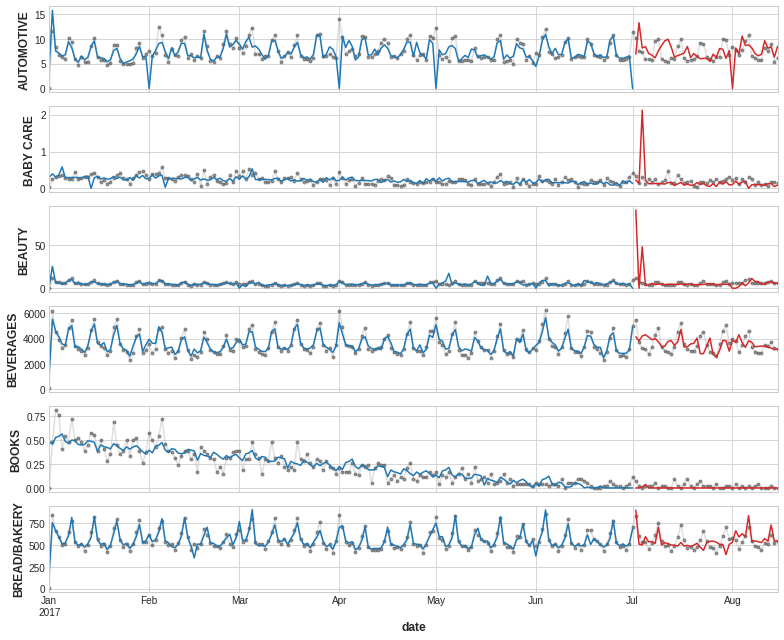

In [73]:
def plot_model_results(model):
    #Split 2017 data into train and validation split after the 1st of July.
    y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":]
    X1_train, X1_valid = X_1[: "2017-07-01"], X_1["2017-07-02" :]
    X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]

    # Some of the algorithms above do best with certain kinds of
    # preprocessing on the features (like standardization), but this is
    # just a demo.
    model.fit(X1_train, X2_train, y_train)
    y_fit = model.predict(X1_train, X2_train).clip(0.0) #.clip(0.0) removes negative values
    y_pred = model.predict(X1_valid, X2_valid).clip(0.0) #.clip(0.0) removes negative values

    families = y.columns[0:6]
    axs = y.loc(axis=1)[families].plot(
        subplots=True, sharex=True, figsize=(11, 9), **plot_params, alpha=0.5,
    )
    _ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
    _ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)
    for ax, family in zip(axs, families):
        ax.legend([])
        ax.set_ylabel(family)
plot_model_results(model)

These are just an examples. You might discover other algorithms you like in the scikit-learn [User Guide](https://scikit-learn.org/stable/supervised_learning.html).

Use the code in this cell above to see the predictions your hybrid makes.

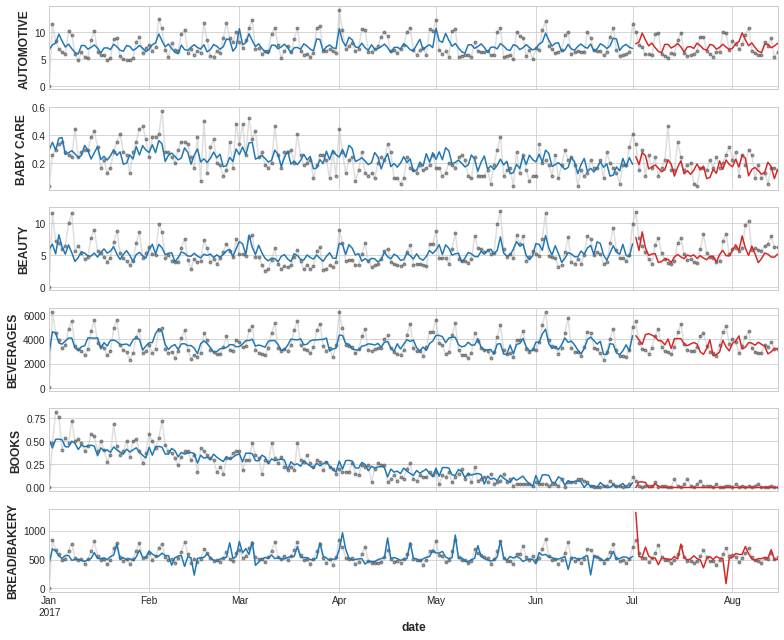

In [74]:
# Model 1 (trend)
from sklearn.linear_model import ElasticNet, Lasso, Ridge

# Model 2
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# Boosted Hybrid

# YOUR CODE HERE: Try different combinations of the algorithms above
model = BoostedHybrid(
    model_1=Lasso(),
    model_2=KNeighborsRegressor(),
)
plot_model_results(model)